In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.api import ExponentialSmoothing, ARIMA, ARMA, arma_order_select_ic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

%matplotlib inline

In [2]:
# 设置图片参数
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['figure.figsize'] = (15, 8)  # 图片大小
plt.rcParams['savefig.dpi'] = 300  # 图片像素
# plt.rcParams['figure.dpi'] = 300  # 分辨率

In [3]:
def error_prop(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

## 1 数据预处理

In [4]:
# 加载数据
data_path = "../data/luggage_compartment_door.txt"
df = pd.read_csv(data_path, sep='\t', encoding='utf-8')

In [5]:
df = df.rename(columns={'物料编码': 'part_id', '物料描述': 'part_name', 
                        '订货数': 'order_num', '缺件数': 'out_of_stock_num', 
                        '受理数': 'delivery_num', '审核日期': 'date', '审核时间': 'time'})

# 将`part_id`的数据类型设为字符串，方便后面进行重采样 
df['part_id'] = df['part_id'].astype('str')

# 重置索引
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df.set_index('date', inplace=True)

In [6]:
# 重采样
df_month = df.resample('M').sum()

In [7]:
train_month = df_month[:-4]
test_month = df_month[-4:]

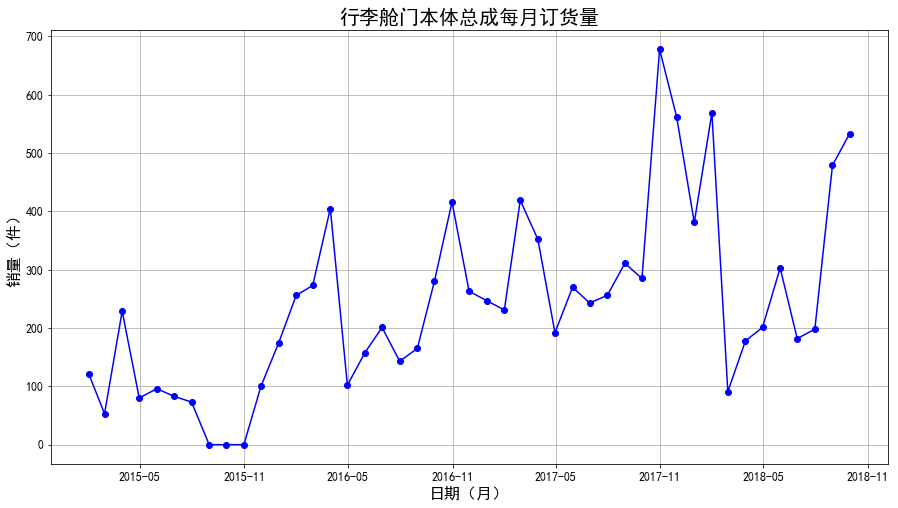

In [8]:
fig, ax = plt.subplots()
ax.plot(df_month.index, df_month.order_num.values, 'bo-')
ax.set_xlabel('日期（月）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每月订货量', fontsize=20)
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## 2 时间序列检验

### 2.1 自相关图和偏自相关图

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


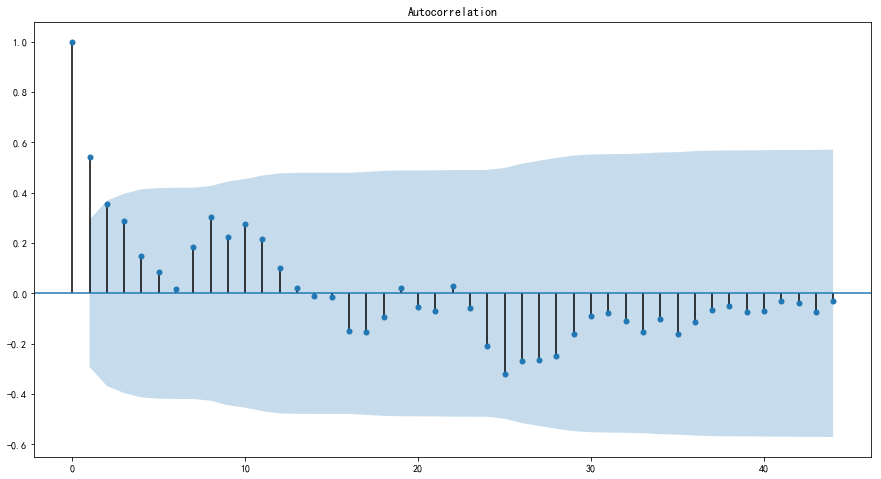

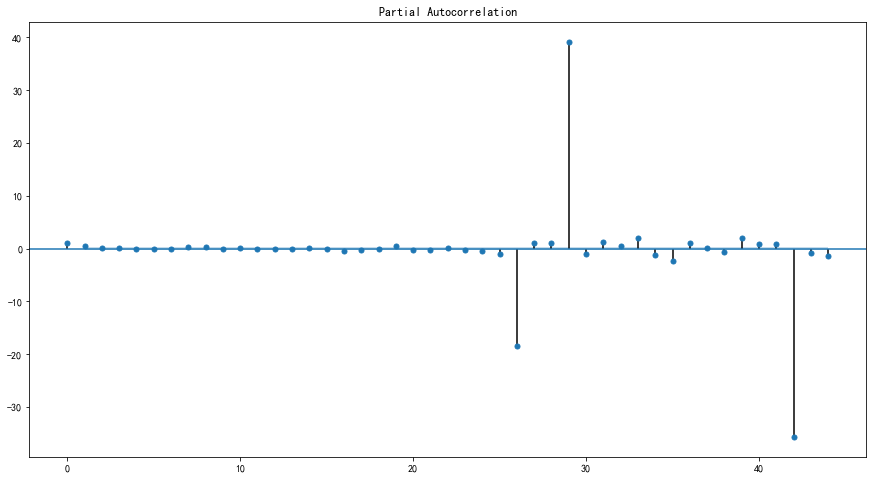

In [9]:
# 月的自相关图
plot_acf(df_month.order_num.values).show()
plot_pacf(df_month.order_num.values).show()

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


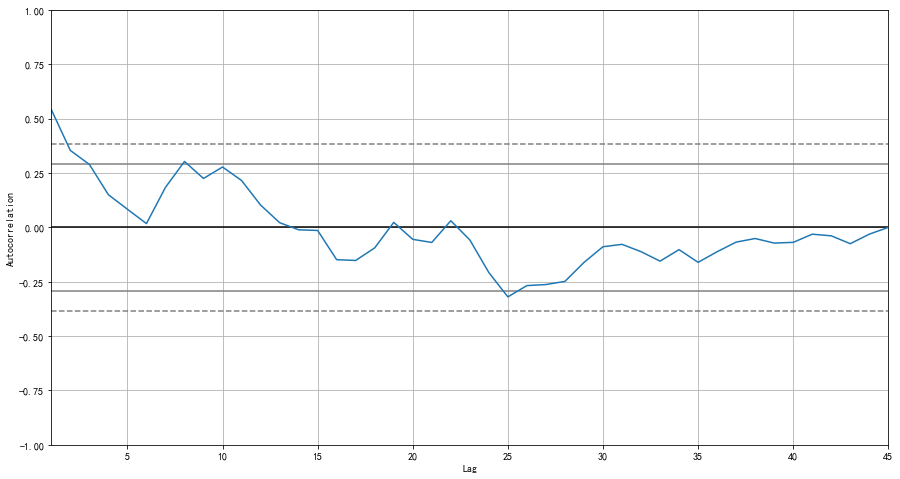

In [10]:
autocorrelation_plot(df_month.order_num.values)
plt.show()

### 2.2 单位根检验

In [11]:
# 月的单位根检验
adf_result = adfuller(df_month.order_num.values)
output = pd.DataFrame(index=["Test Statistic Value", "p-value", "Lags Used", "Number of Observations Used", "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"], columns=['value'])
output['value']['Test Statistic Value'] = adf_result[0]
output['value']['p-value'] = adf_result[1]
output['value']['Lags Used'] = adf_result[2]
output['value']['Number of Observations Used'] = adf_result[3]
output['value']['Critical Value (1%)'] = adf_result[4]['1%']
output['value']['Critical Value (5%)'] = adf_result[4]['5%']
output['value']['Critical Value (10%)'] = adf_result[4]['10%']
print("月的单位根检验结果为：")
print(output)

月的单位根检验结果为：
                                 value
Test Statistic Value          -3.13112
p-value                      0.0243341
Lags Used                            0
Number of Observations Used         44
Critical Value (1%)           -3.58857
Critical Value (5%)           -2.92989
Critical Value (10%)          -2.60318


### 2.3 纯随机性检验

In [12]:
# 月的纯随机性检验
print("序列的纯随机性检验结果为：")
print(acorr_ljungbox(df_month.order_num.values, lags=1)[1][0])

序列的纯随机性检验结果为：
0.00017413039161365664


## 3 模型拟合

### 3.1 Holt-Winters method

In [13]:
train, test = train_month.order_num.values, test_month.order_num.values

In [14]:
model = ExponentialSmoothing(train, seasonal_periods=7, trend='add', seasonal='add')
model_fit = model.fit()
preds = model_fit.forecast(4)

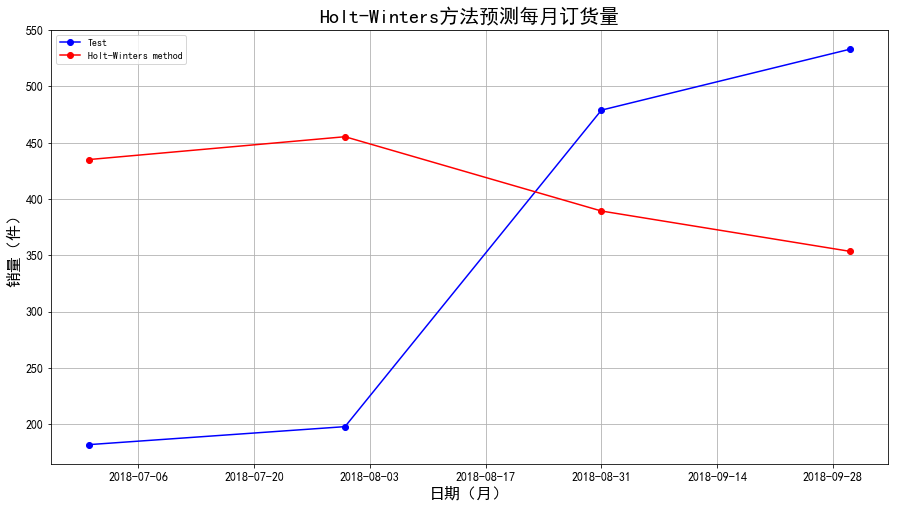

In [15]:
fig, ax = plt.subplots()
# ax.plot(train_month.index, train_month.order_num.values, 'go-', label='Train')
ax.plot(test_month.index,test, 'bo-', label='Test')
ax.plot(test_month.index, preds, 'ro-', label='Holt-Winters method')
ax.set_xlabel('日期（月）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('Holt-Winters方法预测每月订货量', fontsize=20)
ax.legend(loc='best')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [18]:
rmse = sqrt(mean_squared_error(test_month.order_num.values, preds))
print("The RMSE of 'Holt-Winters method' is:", rmse)

The RMSE of 'Holt-Winters method' is: 206.44934304774776


In [17]:
print("The error proportion of Holt-Winters is:", error_prop(test, preds))

The error proportion of Holt-Winters is: 0.5598873576595167


### 3.2 ARIMA

In [19]:
train, test = train_month.order_num.values, test_month.order_num.values

In [37]:
pmax = len(df_month) // 10
qmax = len(df_month) // 10 

bic_matrix = [] 
for p in range(pmax + 1):
    temp = []
    for q in range(qmax + 1):
        try: 
            temp.append(ARIMA(train, (p, 0, q)).fit().aic)
        except:
            temp.append(None)
    bic_matrix.append(temp)

bic_matrix = pd.DataFrame(bic_matrix).astype('float').dropna(axis=1)
p, q = bic_matrix.stack().idxmin()
print("AIC最小的(p, q)值为：(%s, %s)" % (p, q))

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:676: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.p

AIC最小的(p, q)值为：(1, 0)


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:674: RuntimeWarning: divide by zero encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:676: RuntimeWarning: invalid value encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


In [38]:
arma_order_select_ic(train, max_ar=6, max_ma=6, ic='aic')['aic_min_order']

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:676: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anacon

(1, 0)

In [20]:
history = list(train)
preds = list()
for i in range(len(test)):
    model = ARMA(history, order=(1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat)
    obs = test[i]
    history.append(obs)
    print("expected = %f predicted = %f" % (obs, yhat))
error = sqrt(mean_squared_error(test, preds))
print("Test RMSE: %.3f" % error)

expected = 182.000000 predicted = 270.459710
expected = 198.000000 predicted = 201.159239
expected = 479.000000 predicted = 209.914212
expected = 533.000000 predicted = 368.671417
Test RMSE: 163.742


In [21]:
temp = np.array(preds).reshape((len(test), ))
print("The error proportion of ARIMA is:", error_prop(test, temp))

The error proportion of ARIMA is: 0.37717910955436623


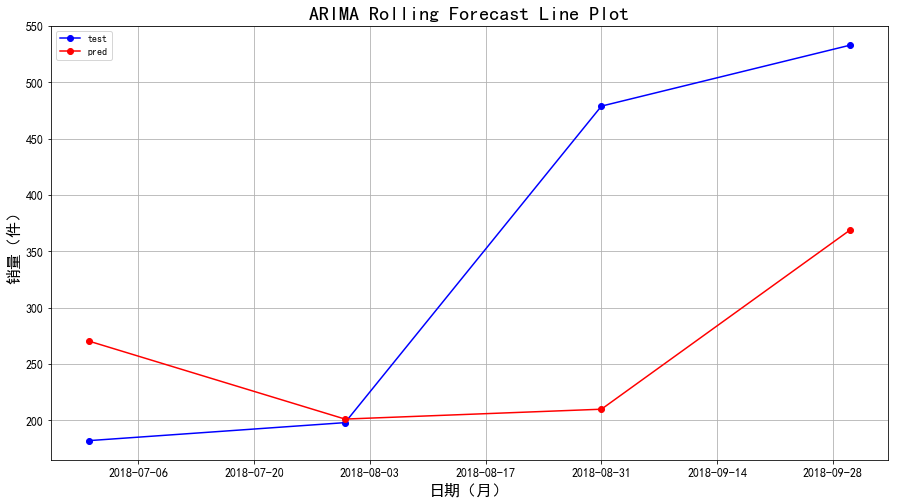

In [22]:
fig, ax = plt.subplots()
ax.plot(test_month.index, test, 'bo-', label='test')
ax.plot(test_month.index, preds, 'ro-', label='pred')
ax.set_xlabel('日期（月）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('ARIMA Rolling Forecast Line Plot', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../figs/ARIMA预测图.png")
plt.show()

### 3.3 SARIMAX

In [23]:
train, test = train_month.order_num.values, test_month.order_num.values

In [ ]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 6)

# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 1) for x in pdq]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = SARIMAX(train,
                              order = param,
                              seasonal_order = param_seasonal,
                              enforce_stationarity=True,
                              enforce_invertibility=True)
            res = tmp_mdl.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'numpy.linalg.linalg.LinAlgError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'numpy.linalg.linalg.LinAlgError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'numpy.linalg.linalg.LinAlgError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'numpy.linalg.linalg.LinAlgError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'numpy.linalg.linalg.LinAlgError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'numpy.linalg.linalg.LinAlgError'>
Unex

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'numpy.linalg.linalg.LinAlgError'>
Unex

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'numpy.linalg.linalg.LinAlgError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'KeyboardInterrupt'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
history = list(train)
preds = list()
for i in range(len(test)):
    model = SARIMAX(train, order=(2, 0, 4), seasonal_order=(0, 1, 1, 7))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat)
    obs = test[i]
    history.append(obs)
    print("expected = %f predicted = %f" % (obs, yhat))
error = sqrt(mean_squared_error(test, preds))
print("Test RMSE: %.3f" % error)

In [ ]:
fig, ax = plt.subplots()
ax.plot(test_wed.index, test, 'bo-', label='test')
ax.plot(test_wed.index, preds, 'ro-', label='pred')
ax.set_xlabel('日期（月）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('SARIMAX Rolling Forecast Line Plot', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../figs/SARIMAX预测图.png")
plt.show()